# Session 2 - Random Forest Training

This is an introductory notebook to familiarize yourself with training and evaluation techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument  and a Random Forest algorithm to perform water classification. This same workflow can be adapted to other applications and by using other algorithms.

The intent of this notebook is three-fold. First we will walk through the fundamentals of a Random Forest algorithm. Next,we will perform some training using the Random Forest algorithm. Finally, we will perform inference using the Random Forest algorith, and will include some metrics to analyze its performance. The entire work is done using the Python programming language and based on a dataset uploaded to Hugging Face.

Author: Caleb S. Spradlin, Jordan A. Caraballo-Vega
Release Date: 2023.04.08
Last Modified: 2023.04.08

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.


In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 8.6 MB/s eta 0:00:00


In [2]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables
In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [3]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

#qaMaskPath = 'qa'
#waterMaskPath = 'v5_outputs'
#test_data_basepath = 'test_data'
#GPU = True
#TILE = 'Golden'
#MODEL = 'rf'

# ratio of the dataset split for testing
TEST_RATIO = 0.2

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our models and visualizations.

In [4]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

Output any columns we will need to drop for training



In [ ]:
colsToDrop

[]

In [ ]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [6]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/nasa-cisto-data-science-group___csv/nasa-cisto-data-science-group--modis-lake-powell-toy-dataset-f7d76bc70ba9ef34/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


CPU times: user 740 ms, sys: 49.7 ms, total: 789 ms
Wall time: 2.79 s


After we download our dataset, we proceed to split it into training and test set. Note how the water column is set as the y feature and is dropped from the X features.

In [7]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

For this exercise we have downloaded our data directly from Hugging Face where we already had made the split between training and test. However, how would you do it if your dataset was not splitted already?

One way to achieve this is by using the train_test_split function from sckit-learn to directly split these features into train and test set. Here we take an example 800 rows dataset and split it into training and test sets:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset.drop(['water'], axis='columns'),
    train_dataset['water'],
    random_state=RANDOM_STATE,
    train_size=0.80,
)

Lets look at the distribution of our classes after the split:

In [9]:
y_train.value_counts(), y_test.value_counts()

(1    322
 0    318
 Name: water, dtype: int64,
 1    83
 0    77
 Name: water, dtype: int64)

The distribution of the training and test features are close to 50% water and 50% not-water on each. scikit-learn train_test_split() provides another parameter where the stratification of the test dataset is forced to match the one of the training dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset.drop(['water'], axis='columns'),
    train_dataset['water'],
    random_state=RANDOM_STATE,
    train_size=0.70,
    stratify=train_dataset['water']  # TODO: double check what this means
)

In [12]:
y_train.value_counts(), y_test.value_counts()

(1    284
 0    276
 Name: water, dtype: int64,
 1    121
 0    119
 Name: water, dtype: int64)

Note how we now have a larger number of test samples, and smaller number of training samples. Which one to choose will depend on the problem you have in hand.

## 4. Training Preparation

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [13]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [14]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


Like we did in the first exercise of this Session, we can look at some of the features of the data before proceeding to train.

In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,560.0,1204.898214,1258.518881,15.0,234.50,899.5,1882.00,9045.0
sur_refl_b02_1,560.0,1568.241071,1526.138500,1.0,165.25,1429.0,2662.25,8795.0
sur_refl_b03_1,560.0,747.867857,982.646604,-100.0,288.00,555.0,860.00,8844.0
sur_refl_b04_1,560.0,1028.750000,1042.995031,6.0,404.75,813.0,1320.00,9056.0
sur_refl_b05_1,560.0,1947.705357,1440.492111,-92.0,557.75,1802.5,3178.50,6382.0
sur_refl_b06_1,560.0,1912.583929,1519.511426,51.0,514.25,1459.5,3196.00,6610.0
sur_refl_b07_1,560.0,1570.451786,1373.370210,5.0,320.75,1192.5,2657.75,6128.0
ndvi,560.0,65.605357,2546.290592,-9493.0,-1630.50,712.5,1721.75,8587.0
ndwi1,560.0,-2338.526786,3451.658914,-9862.0,-4629.25,-1547.5,-715.75,8823.0
ndwi2,560.0,-1005.717857,3793.531161,-9692.0,-2856.00,-695.0,798.75,9453.0


We can also use thresholding methods based on our physical knowledge to extract interesting features of outliers that we might want to visualize later when evaluating the model.

In [16]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [17]:
output_interesting_idx(X_train, 'ndvi', 1000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
770,1798,2465,755,1229,3201,3397,2891,1564,-1589,-795
167,1895,2769,850,1372,3679,3569,2852,1873,-1262,-147
371,1737,2362,558,911,3049,3448,3067,1524,-1869,-1298
357,1828,2525,972,1412,3092,3299,2829,1601,-1328,-567
173,1987,2906,1063,1638,3462,3842,3351,1878,-1387,-711
...,...,...,...,...,...,...,...,...,...,...
187,2511,3490,857,1419,4525,4825,4148,1631,-1605,-861
449,940,2034,405,669,2291,2114,1533,3678,-192,1404
794,2214,3229,877,1384,3575,3278,2754,1864,-75,793
76,2099,3118,552,1313,3676,3994,3080,1953,-1231,61


## 5. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages.

In [18]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

Here we define the classifier:

In [20]:
classifier = skRF(**hyperparameters)

## 5.1 k-Fold fitting

Then we can proceed to train our model using the k-Fold approach.

In [21]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 

In [22]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9928571428571429
Best accuracy score: 1.0


## 5.2 Regular fitting

We can also train our model without doing any k-Fold cross-validation.

In [23]:
classifier = skRF(**hyperparameters)

In [24]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 1.14 s, sys: 130 ms, total: 1.27 s
Wall time: 1.03 s


RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

In [26]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.9875


## 6. Model testing and training/testing data validation

Once we have trained our model we can proceed to use the best model and perform testing and validation using our dataset.

### 6.1 Get model metrics

We can calculate accuracy metrics from our model using the test dataset, but we can also output prediction probabilities to understand the drivers behind the model performance.

In [27]:
classifier = bestModel

In [28]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.992

In [29]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

Here we can take the prediction probabilities straight out of the model so we can visualize them.

In [30]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### 6.1.1 Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

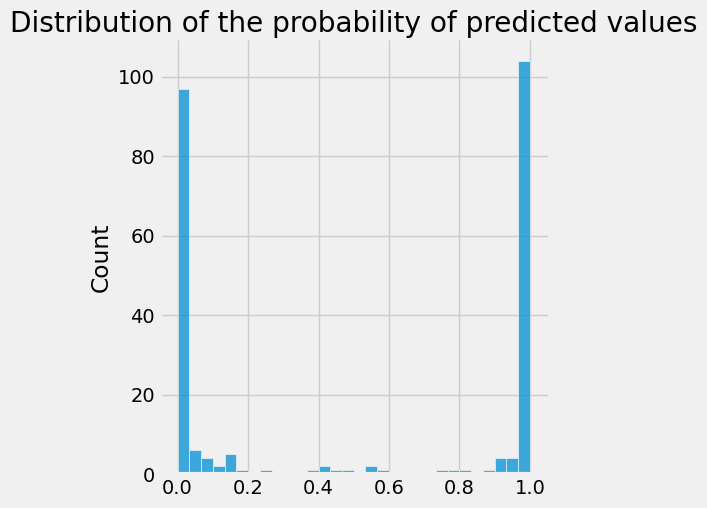

In [31]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [32]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

## 6.2 Additional Metrics 

We can compute additional metrics to understand model performance related to producer and user accuracy.

In [33]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       119
           1       1.00      0.98      0.99       121

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

Test Recall
-------------------------------------------------------
1.0
Confusion Matrix
-------------------------------------------------------
[[119   0]
 [  2 119]]


We can also look at Receiver Operating Characteristic (ROC) plots to understand the performance of the model across all samples between True Positive and False Positive rates.

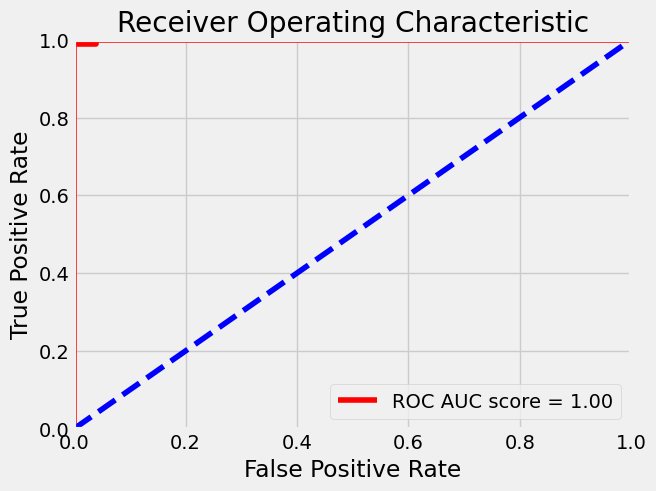

In [ ]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 6.3 Permutation Importance

Another important metric to understand model performance is to evaluate permutation importance, particularly focuse on the importance of each feature in the training and inference of the model.

In [34]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 9.81 s, sys: 1.11 s, total: 10.9 s
Wall time: 12.3 s


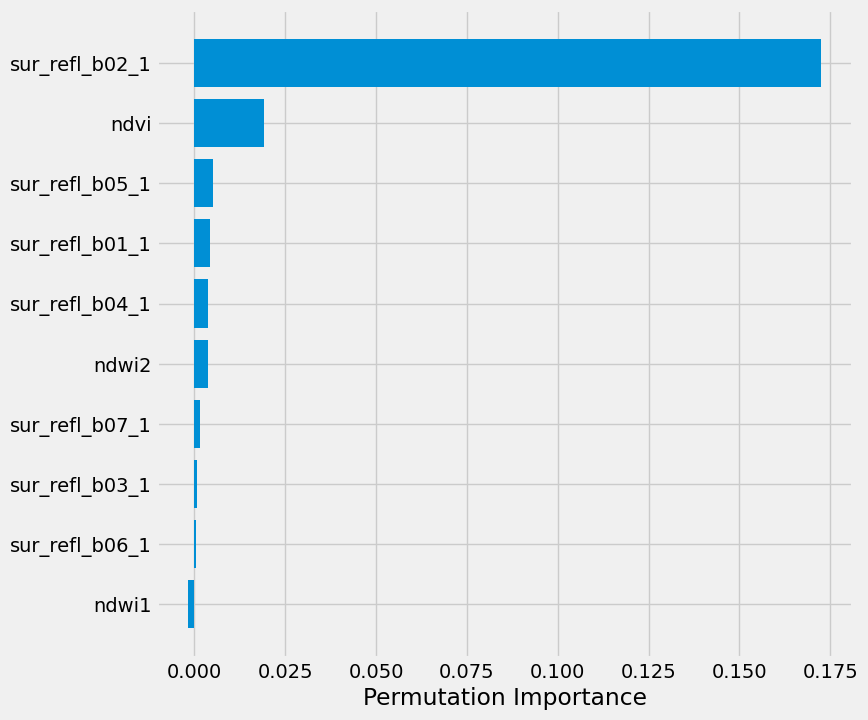

In [35]:
png_save_path = 'mw_{}_{}_rf_{}_permutation_importance.png'.format(
    score,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

Garbage collection

In [36]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## 7. Save the model for future use

We can then save our model for future use.

In [37]:
model_save_path = 'mw_{}_{}_{}_2.0.0_tuned_{}.sav'.format(score,
                                                             hyperparameters['n_estimators'],
                                                             'cpu',
                                                             datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: models/mw_0.992_400_cpu_2.0.0_tuned_2023_04_11_14_30.sav
RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)


['models/mw_0.992_400_cpu_2.0.0_tuned_2023_04_11_14_30.sav']

NEED TO FIX FROM HERE

Load raster, put into dataframe, predict, visualize in folium

## 8. Testing: Raster Inference

In [ ]:
import rioxarray as rxr

raster = 

In [ ]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

ModuleNotFoundError: ignored

In [ ]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [ ]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

In [ ]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [ ]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [ ]:
%%time
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

In [ ]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [ ]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

## Inputreshapet raster: description and histogram

In [ ]:
df.describe().T

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [ ]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [ ]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [ ]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

In [ ]:
plt.matshow(waterMasked)

# Generating stats for predicted and truth

## Predicted Raster

In [ ]:
import math

In [ ]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

In [ ]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

In [ ]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

### Model metrics on raster data

In [ ]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

## Output predicted raster to GeoTiff

In [ ]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [ ]:
import folium
from folium import plugins
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [ ]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [ ]:
outPath

In [ ]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [ ]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())